In [1]:
import data
import stack
import transformations as trans
import nibabel as nib
import torch as t
import os
import numpy as np
import open3d as o3d
import pytorch3d as p3

read nifti format and return image, affine and zooms as torch tensor, show slices (not in world coordinates)

0

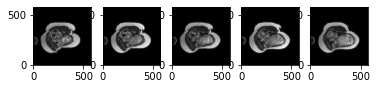

In [2]:
filename = "iFIND00472_iFIND2_201901111210_PHILIPSJ2LF9B9_101_PIH1HR_Survey_32SENSE.s1.nii.gz"
t_image, t_affine, zooms = data.nii_to_torch(filename)
data.show_slice(t_image)

Create stack object

0

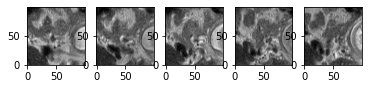

In [3]:
t_image_red = t_image[200:300,200:300,:]
data.show_slice(t_image_red)

In [4]:
beta = 0.01
first_stack = stack.stack(t_image_red,t_affine, beta)
first_slice = stack.slice_2d(t_image_red[:,:,0],t_affine)

/Users/constantin/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640812094853/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


create target volume from desired geometry and the number of voxels in each direction

In [5]:
corners = first_stack.corners()
corners

tensor([[185.6714, 287.5000],
        [185.6714, 287.5000],
        [  2.0000,   2.9091]], dtype=torch.float64)

In [6]:
geometry = t.tensor([[184,290],[184,290],[2,3]])
n_voxels = t.tensor([50,50,5])
target = stack.volume(geometry,n_voxels)

create slice and target volume

get the target volume and get p_s_tilde

In [7]:
target_p_r = target.p_r
p_s_tilde = target.p_s_tilde(first_slice.F)
p_s = first_slice.p_s
print(f'target p_r: {target_p_r.shape} p_s_tilde: {p_s_tilde.shape} p_s: {p_s.shape}')

target p_r: torch.Size([5, 12500]) p_s_tilde: torch.Size([4, 12500]) p_s: torch.Size([5, 10000])


transpose p_s_tilde and p_s for creating the distance matrix

In [8]:
p_s_tilde_t = p_s_tilde.transpose(0,1).float()
p_s_t = p_s.transpose(0,1).float()
distance_matrix = t.cdist(p_s_t[:,:4], p_s_tilde_t)
print(f'distance_matrix: {distance_matrix.shape}')

distance_matrix: torch.Size([10000, 12500])


create list of indices with the closest points in target mesh to pixels

In [9]:
closest_ps_tilde = t.min(distance_matrix,1).indices
print(f'closest_ps_tilde: {closest_ps_tilde.shape}')

closest_ps_tilde: torch.Size([10000])


create distance_vector between p_s and p_s_tilde (indexed at the closest points)

In [10]:
distance_vector = t.sub(p_s[:3,:],p_s_tilde[:3,closest_ps_tilde])
print(f'distance_vector {distance_vector.shape}')

distance_vector torch.Size([3, 10000])


In [11]:
for i in range(0,closest_ps_tilde.shape[0]):
    target_index = closest_ps_tilde[i]
    target.p_r[4,target_index] += stack.PSN_Gauss(distance_vector[:,i])*p_s[4,i]

In [12]:
target.create_X()

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [4.1378e-18, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [6.7258e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         ...,
         [5.9845e-10, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.0637e-12, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.3331e-15, 0.0000e+00, 0.0000e+00,

In [13]:
target.affine

tensor([[   2.1200,    0.0000,    0.0000, -184.0000],
        [   0.0000,    2.1200,    0.0000, -184.0000],
        [   0.0000,    0.0000,    0.2000,   -2.0000],
        [   0.0000,    0.0000,    0.0000,    1.0000]])

In [14]:
nft_img = data.torch_to_nii(target.X, target.affine)

filename = 'first_nifti'
data.save_nifti(nft_img,filename)